# Aim
The aim of this notebook is to help fraud detection using the **transaction** and **identity** datasets


# Important Points for training

###  1. Class imbalance

* Systematic study on dealing with class imbalance in the context on CNN https://arxiv.org/abs/1710.05381

From the paper:

*Based on results from our experiments we conclude that (i) the effect of class imbalance on classification performance is detrimental; (ii) the method of addressing class imbalance that emerged as dominant in almost all analyzed scenarios was oversampling; (iii) oversampling should be applied to the level that completely eliminates the imbalance, whereas the optimal undersampling ratio depends on the extent of imbalance; (iv) as opposed to some classical machine learning models, oversampling does not cause overfitting of CNNs; (v) thresholding should be applied to compensate for prior class probabilities when overall number of properly classified cases is of interest*

Important point, only oversampling the training set.

Basic method: 

Random minority oversampling, which simply replicates randomly
selected samples from minority classes

Current tools: https://imbalanced-learn.readthedocs.io/en/stable/api.html


### 2. Time Component in the validation set

We should calibrate the validation set, to make sure it aligns with the test set
performance.

* Performance on val set is much higher when using random shuffe
* Need to figure out which validation set better correlations with the Kaggle Test set

### 3. Model Explainability

https://github.com/slundberg/shap or lime. There is a function within lightgbm that 
will return feature contribution. 

### 4. Competition Metric

The relevant metric is the area under the ROC curve, see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

For details see https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py


### 5. Effectively tunning Hyper-parameters

https://github.com/fmfn/BayesianOptimization

For an sklearn example, see https://github.com/fmfn/BayesianOptimization




## TODO: 

1. Get baysian hyper-parameter tunning to work
2. Look at feature importance when predicting time-split
3. Reorginize code to make it much easier to iterate on ideas -- keep train parts together
4. Get code working on sagemaker -- need more RAM!



# Experiments

1. Training on the more recent dataset improved performance from 0.9 to 0.91 -- Still only 30% of data used
2. Effect of using 100% of data for predictions. Using all data improve val slightly, from 0.893 to 0.895
3. Only using a small subsample is perfectly fine. 
4. Best predictor of accuracy us Time-Split validation -- should directly correlate model
5. Re-structure notebook to make it easier to use.


In [1]:

%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:

from src.utils import *
from src.training_utils import *   
import gc  # garbage collection use gc.collect to collect deleted arrays (del a)


In [3]:

import pandas as pd
import numpy as np
import lightgbm as lgb
from IPython.display import display, HTML
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from imblearn.over_sampling import RandomOverSampler
from lightgbm import LGBMClassifier # This is the sklearn style wrapper for lightgbm
from pdpbox import pdp
import seaborn as sns
import random, os
from sklearn.preprocessing import LabelEncoder


In [4]:
# Make everything deterministic

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 42
seed_everything(SEED)


In [5]:

# Create a list of all the variables that should be treated as categories.
cat_variables = ['ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] \
    + [f'card{id}' for id in range(1,6+1)] \
    + [f'M{id}' for id in range(1,9+1)] \
    + ['DeviceType', 'DeviceInfo'] + [f'id_{ix}' for ix in range(12,38+1)]


In [ ]:

le.fit([1, 2, 2, 6])
LabelEncoder()
>>> le.classes_
array([1, 2, 6])
>>> le.transform([1, 1, 2, 6])
array([0, 0, 1, 2])
>>> le.inverse_transform([0, 0, 1, 2])


In [5]:

PATH = './data/'


In [6]:

!ls ./data/


sample_submission.csv	   test_transaction.csv      train_transaction.csv
sample_submission.csv.zip  test_transaction.csv.zip  train_transaction.csv.zip
test_identity.csv	   train_identity.csv
test_identity.csv.zip	   train_identity.csv.zip


## 1. Read in and inspect the data


In [15]:

# Load the main data, use all the rows to infer the datatype.
df_transaction_raw = pd.read_csv(f'{PATH}train_transaction.csv', low_memory=False)
#df_identity_raw = pd.read_csv(f'{PATH}train_identity.csv', low_memory=False)


In [16]:

df_identity_raw = pd.read_csv(f'{PATH}train_identity.csv', low_memory=False)


In [17]:

feature_count = df_transaction_raw.shape[1]
row_count = df_transaction_raw.shape[0]

print(f'Number of features = {feature_count} (transaction only)')
print(f'Number of rows = {row_count} (transaction only)')

feature_count = df_identity_raw.shape[1]
row_count = df_identity_raw.shape[0]

print(f'Number of features = {feature_count} (identity only)')
print(f'Number of rows = {row_count} (identity only)')

# Only 20% of transactions have corresponding identity information.


Number of features = 394 (transaction only)
Number of rows = 590540 (transaction only)
Number of features = 41 (identity only)
Number of rows = 144233 (identity only)


In [18]:

# Combine the transaction and identity datasets.
df_raw = df_transaction_raw.merge(right=df_identity_raw, how='left', on='TransactionID')


In [ ]:

# my version of convert to cats
convert_to_cats


In [20]:

df_raw.head()


TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987002        0          86469           59.00         W   4663   
1        2987006        0          86522          159.00         W  12308   
2        2987007        0          86529          422.50         W  12695   
3        2987012        0          86564           50.00         W   3786   
4        2987024        0          86821           73.95         W  10112   

   card2  card3 card4  card5  ... id_31  id_32  id_33  id_34  id_35 id_36  \
0  490.0  150.0  visa  166.0  ...   NaN    NaN    NaN    NaN    NaN   NaN   
1  360.0  150.0  visa  166.0  ...   NaN    NaN    NaN    NaN    NaN   NaN   
2  490.0  150.0  visa  226.0  ...   NaN    NaN    NaN    NaN    NaN   NaN   
3  418.0  150.0  visa  226.0  ...   NaN    NaN    NaN    NaN    NaN   NaN   
4  360.0  150.0  visa  166.0  ...   NaN    NaN    NaN    NaN    NaN   NaN   

  id_37  id_38  DeviceType  DeviceInfo  
0   NaN    NaN         NaN         NaN  
1   NaN    NaN         NaN         NaN  
2   NaN    NaN         NaN         NaN  
3   NaN    NaN         NaN         NaN  
4   NaN    NaN         NaN         NaN  

[5 rows x 434 columns]

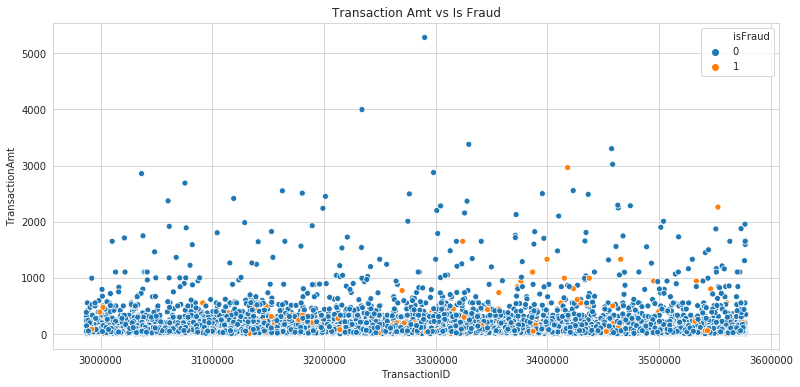

In [34]:

# Relationship between fraud and datetime and fraud and TranscationID
ax = plt.figure(figsize=(13,6))
plt.title('Transaction ID/DT vs Is Fraud')
sns.scatterplot(x='TransactionID', y='TransactionAmt', hue='isFraud', data=df_raw.sample(10000))


NameError: name 'df_raw' is not defined

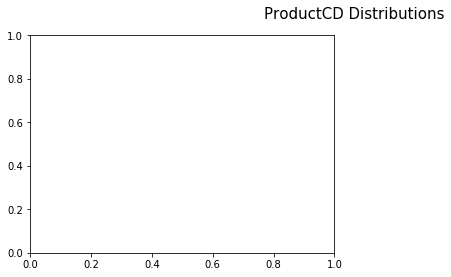

In [9]:

plt.figure(figsize=(12,4))
plt.suptitle('ProductCD Distributions', fontsize=15)

plt.subplot(121)
sns.countplot(x='ProductCD', data=df_raw)

plt.subplot(122)
sns.countplot(x='ProductCD', hue='isFraud', data=df_raw)


In [19]:

# Lets subsample to avoid memory issues
print('Creating subsampe of main dataset...')
df_raw = create_df_subsample(df_raw, subsample_frac=0.3)
df_raw.head()


Creating subsampe of main dataset...
Frac subsampling = 0.3


TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987002        0          86469           59.00         W   4663   
1        2987006        0          86522          159.00         W  12308   
2        2987007        0          86529          422.50         W  12695   
3        2987012        0          86564           50.00         W   3786   
4        2987024        0          86821           73.95         W  10112   

   card2  card3 card4  card5  ... id_31  id_32  id_33  id_34  id_35 id_36  \
0  490.0  150.0  visa  166.0  ...   NaN    NaN    NaN    NaN    NaN   NaN   
1  360.0  150.0  visa  166.0  ...   NaN    NaN    NaN    NaN    NaN   NaN   
2  490.0  150.0  visa  226.0  ...   NaN    NaN    NaN    NaN    NaN   NaN   
3  418.0  150.0  visa  226.0  ...   NaN    NaN    NaN    NaN    NaN   NaN   
4  360.0  150.0  visa  166.0  ...   NaN    NaN    NaN    NaN    NaN   NaN   

  id_37  id_38  DeviceType  DeviceInfo  
0   NaN    NaN         NaN         NaN  
1   NaN    NaN         NaN         NaN  
2   NaN    NaN         NaN         NaN  
3   NaN    NaN         NaN         NaN  
4   NaN    NaN         NaN         NaN  

[5 rows x 434 columns]

In [13]:

# Save temp raw data.
df_raw.to_feather('tmp/fraud_data_raw_sample.feather')


In [7]:

# Load temp raw data
df_raw = pd.read_feather('tmp/fraud_data_raw_sample.feather')


In [8]:

df_raw = add_features(df_raw, feature_set_names=['agg_spend_stats'])


Adding aggreate amount spent stats...


In [9]:

# Remove infinite values..
df_raw = clean_inf_nan(df_raw)



## 2. Categorical dependent variables

1. Count how many unique classes there are for each categorical variable
2. Plot cases with less than 10 classes


In [15]:

# Count the number of classes in each catagorical variable.
unique_class_count = {}
for feature_name in cat_variables:
    class_count = df_raw[feature_name].unique().shape[0]
    unique_class_count[feature_name] = class_count

print('Number of class/cat per each catagorical variables')
unique_class_count


Number of class/cat per each catagorical variables


{'ProductCD': 5,
 'addr1': 333,
 'addr2': 75,
 'P_emaildomain': 60,
 'R_emaildomain': 61,
 'card1': 13553,
 'card2': 501,
 'card3': 115,
 'card4': 5,
 'card5': 120,
 'card6': 5,
 'M1': 3,
 'M2': 3,
 'M3': 3,
 'M4': 4,
 'M5': 3,
 'M6': 3,
 'M7': 3,
 'M8': 3,
 'M9': 3,
 'DeviceType': 3,
 'DeviceInfo': 1787,
 'id_12': 3,
 'id_13': 55,
 'id_14': 26,
 'id_15': 4,
 'id_16': 3,
 'id_17': 105,
 'id_18': 19,
 'id_19': 523,
 'id_20': 395,
 'id_21': 491,
 'id_22': 26,
 'id_23': 4,
 'id_24': 13,
 'id_25': 342,
 'id_26': 96,
 'id_27': 3,
 'id_28': 3,
 'id_29': 3,
 'id_30': 76,
 'id_31': 131,
 'id_32': 5,
 'id_33': 261,
 'id_34': 5,
 'id_35': 3,
 'id_36': 3,
 'id_37': 3,
 'id_38': 3}

In [16]:

# Get a list of cat variables that we can plot
low_class_cat_variables = [name for name, count in unique_class_count.items() if count < 10]


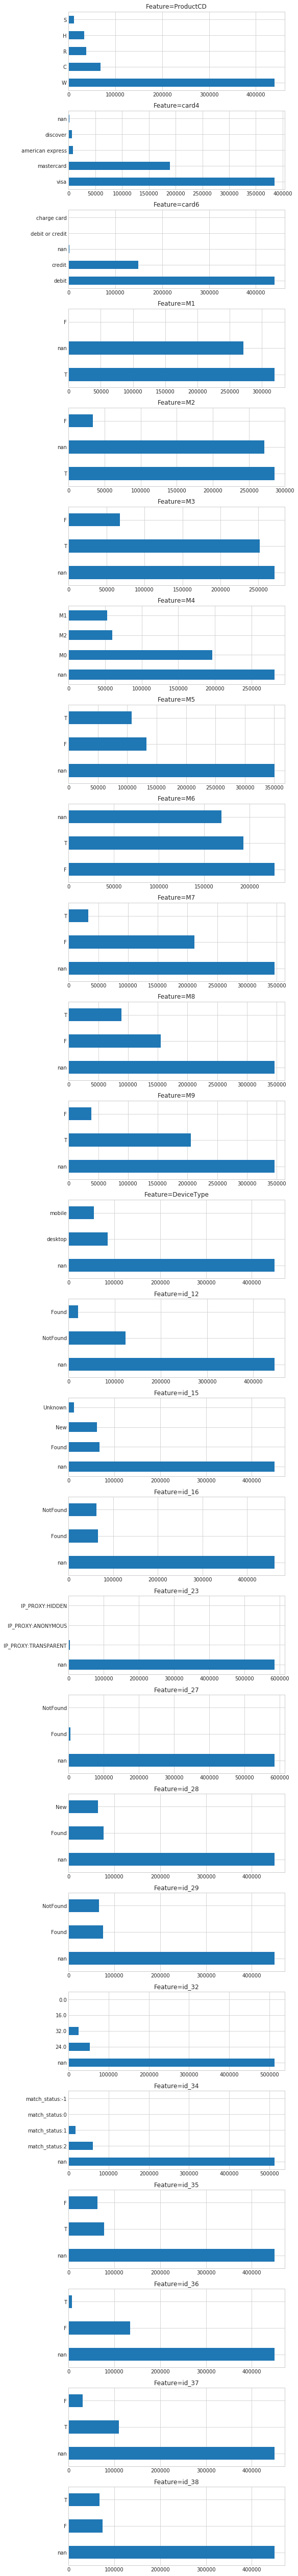

In [17]:

# Plot bar plots of a sample of cat variables
fig, ax = plt.subplots(ncols=1, 
                       nrows=len(low_class_cat_variables), 
                       constrained_layout=True, 
                       figsize=(8,70),
                       squeeze=True)

for ix, cat_feature in enumerate(low_class_cat_variables):
    cat_class_counts = df_raw[cat_feature].value_counts(dropna=False)
    cat_class_counts.plot.barh(title=f'Feature={cat_feature}', ax=ax[ix])
    


## 3. Measure the class imbalance -- independent variable!

Obvious massive class imbalance!
3% of transitions are labelling an fradulant!


0    569877
1     20663
Name: isFraud, dtype: int64
Ratio of Fraud to non-fraud = 3.63%


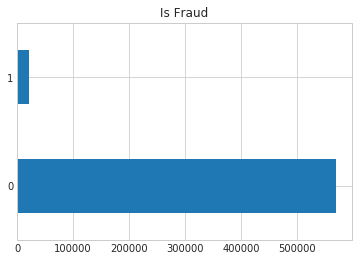

In [18]:

fraud_counts = df_raw.isFraud.value_counts()
print(fraud_counts)

class_imbalance_ratio = round(100 * (fraud_counts.values[1] / fraud_counts.values[0]),2)
print(f'Ratio of Fraud to non-fraud = {class_imbalance_ratio}%')

fraud_counts.plot.barh(title='Is Fraud');



## 4. Dealing with categorical data -- update types

1. convert all know cat columns + string columns to pandas cat variables



In [10]:

# Update the types of all non-numeric columns
df_encoded = convert_to_cats(df_raw, force_cats=cat_variables)


#### 4.1 Check categorical type converstion worked


In [20]:

df_raw.ProductCD.dtype


CategoricalDtype(categories=['C', 'H', 'R', 'S', 'W'], ordered=True)

In [21]:

df_raw.DeviceType.dtype


CategoricalDtype(categories=['desktop', 'mobile'], ordered=True)


## 2. Missing data

We will deal with missing data by 
1. Filling numeric cols with the median 
2. Keeping track of missing data using a is_na columns.


In [30]:

print('How much missing data is there?..Lots')
# Print list of the pecentage of missing data in each column.
(100 * df_encoded.isnull().sum()/len(df_encoded)).sort_values(ascending=False).head(10)


How much missing data is there?..Lots


id_24    99.093547
id_25    99.019444
id_07    99.012660
id_08    99.012660
id_21    99.012138
id_26    99.012138
id_27    99.010051
id_22    99.010051
id_23    99.010051
dist2    92.760377
dtype: float64

In [11]:

print('Fixing NA values')
df_encoded = fix_na_dataframe(df_encoded)


Fixing NA values



#### 2.1 Test if nan fill worked on D7 column


In [23]:

# Check if there are any nulls in D7 columns
df_encoded.D7.isnull().sum()


0

## 3. Make categorical variables numeric (0 indicates na)

In [12]:

df_processed = numericalize_cat_variables(df_encoded, max_n_cat=10)


In [25]:

test_cols = [text for text in df_processed.columns.values if 'M4' in text]
df_processed[test_cols].head()


M4_M0  M4_M1  M4_M2  M4_nan
0      0      0      1       0
1      1      0      0       0
2      1      0      0       0
3      1      0      0       0
4      0      0      0       1


## 4. Save processed data

In [10]:

df_processed.to_feather('tmp/fraud_data.feather')

# The 'df_encoded' df is needed to get the correct encodings from 
# the train data. 
df_encoded.to_feather('tmp/fraud_data_wt_encodings.feather')


NameError: name 'df_processed' is not defined


## 5. Load processed data -- new starting point


In [8]:

df_processed = pd.read_feather('tmp/fraud_data.feather')
df_encoded = pd.read_feather('tmp/fraud_data_wt_encodings.feather')


## 6. Feature eng 

1. time delta
2. Amt spent -- need historical average

Likely we can get some useful information out of these time-deltas

* Has the amount of fraud increased with time?
* Can we extract any useful time-component for cylical trends



## 6. Create train/validation sets and split off dependent variable

Likely should be a time ordered cut! Can also experiment with other
cuts and see if they correlate better with the test set.


In [8]:

X_train, y_train, X_val, y_val = create_training_val_set(df_processed, split_by_time=True, 
                                                         drop_features=['TransactionDT', 'TransactionID'])


Ordering train/val split by TransactionDT
Removing features ['TransactionDT', 'TransactionID']
Using 70.0 % for Training set
Train size = 134138
Validation size = 57488


In [9]:

feature_count = X_train.shape[1]

print(f'Feature space = {feature_count}')
print(f'Fraud Examples in train set = {y_train.sum()}')
print(f'Fraud Examples in validation set = {y_val.sum()}')


Feature space = 901
Fraud Examples in train set = 14521
Fraud Examples in validation set = 6142


### 6.1 Check that there is a clear time split between the train and validation sets

In [12]:

ax = X_train.TransactionDT.hist(label='Train Set')
ax.set_xlabel('time-delta');
X_val.TransactionDT.hist(label='Val Set', ax=ax)
plt.legend()


AttributeError: 'DataFrame' object has no attribute 'TransactionDT'

## 7. Oversample the training set -- removing class imbalance

This will be an important part of improving results on this dataset. There 
are a lot of different options which one can try in the class imbalance package.


In [10]:

# resample training data.
(X_train_res, y_train_res) = random_over_sampler(X_train, y_train)


Check class imbalance..Should be equal post Oversampling


1    119617
0    119617
dtype: int64


## 8. Training the model -- First pass lightGBT with feature importance

* Does oversampling help the AUC ROC metric -- it may not reflect the class imbalance well?

* AUC ROC is a bad metric for this competition -- recall should be the most important measure


In [11]:

# Very basic initial parameters, just used for feature importance etc..
m_balanced = LGBMClassifier(
    learning_rate=0.1, 
    n_estimators=100, 
    subsample=0.1, # Used to speed up training 
    colsample_bytree=0.5, 
    importance_type='split',
    n_jobs=-1)

# Balanced classes
m_balanced.fit(X=X_train_res.values,y=y_train_res.values)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.1, subsample_for_bin=200000, subsample_freq=0)


### 8.1 Validation error: Precision, Recall, and ROC


In [12]:

show_validation_error(m_balanced, X_train, y_train, X_val, y_val, model_name='m_balanced', show_report=True)


Results for model = m_balanced:
	 Validation set: AUC ROC = 0.9012
	 Training set: AUC ROC = 0.9464
Classification report Validation set:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93     51346
           1       0.46      0.73      0.56      6142

    accuracy                           0.88     57488
   macro avg       0.71      0.81      0.75     57488
weighted avg       0.91      0.88      0.89     57488




## 8.1 Feature importance

Here we will construct a list of relevant features any only use those for subsequent analysis. 


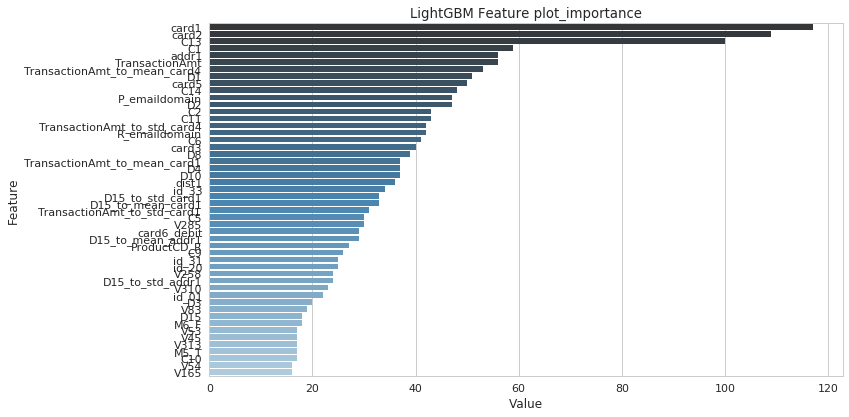

<Figure size 432x288 with 0 Axes>

In [13]:

plot_importance(m_balanced, X_train, num=50)



### 8.2 Find a good cutoff threshold, for feature importance


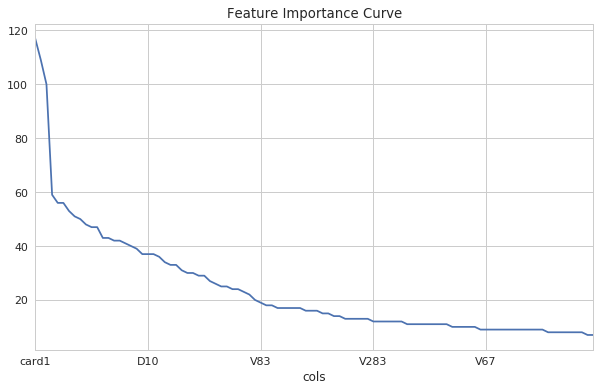

In [14]:

# To truncate features we want to see where the feature importance
# gets relatively small

# Get feature importance
fi = rf_feat_importance(m_balanced, X_train)
fi[:100].plot('cols', 'imp', figsize=(10,6), legend=False, title='Feature Importance Curve');


In [22]:

# List of features to keep.
CUT_THRESHOLD = 10 # From inspecting the above curve.
features_to_keep = list(fi[fi.imp > CUT_THRESHOLD].cols.values)
print(f'Count features to keep = {len(features_to_keep)}')
print(f'Selected features to keep = {features_to_keep}')


Count features to keep = 74
Selected features to keep = ['card1', 'card2', 'C13', 'C1', 'TransactionAmt', 'addr1', 'TransactionAmt_to_mean_card4', 'D1', 'card5', 'C14', 'D2', 'P_emaildomain', 'C11', 'C2', 'TransactionAmt_to_std_card4', 'R_emaildomain', 'C6', 'card3', 'D8', 'D4', 'D10', 'TransactionAmt_to_mean_card1', 'dist1', 'id_33', 'D15_to_mean_card1', 'D15_to_std_card1', 'TransactionAmt_to_std_card1', 'V285', 'C5', 'D15_to_mean_addr1', 'card6_debit', 'ProductCD_R', 'C9', 'id_31', 'id_20', 'D15_to_std_addr1', 'V258', 'V310', 'id_01', 'D3', 'V83', 'D15', 'M6_F', 'M5_T', 'V45', 'C10', 'V313', 'V53', 'V165', 'V54', 'D15_to_mean_card4', 'V320', 'id_30', 'V315', 'C8', 'V314', 'C3', 'DeviceInfo', 'card4_discover', 'id_02_to_std_card1', 'V283', 'id_09', 'D15_to_std_card4', 'V281', 'V87', 'C12', 'M6_T', 'V311', 'id_02', 'V62', 'V317', 'V296', 'V294', 'id_18']


In [23]:

# Make sure we keep these two features
required_features = ['TransactionDT', 'TransactionID', 'isFraud']

for req_feature in required_features:
    if req_feature not in features_to_keep:
        features_to_keep += [req_feature]


In [24]:

# Save the good features
pd.Series(features_to_keep).to_csv('tmp/best_features.csv', header=False)


## 8.3 Create train and validation sets with new feature

1. Once the bad features are removed we should redo the feature importance.


In [9]:

# Load the list of the best features
features_to_keep = list(pd.read_csv('tmp/best_features.csv', index_col=0).values.flatten())
# Create a subset with only the important features.
df_subset = df_processed[features_to_keep]



### Retrain on new feature set


In [28]:

# Split data up and subsample
X_train_tmp, y_train_tmp, X_val_tmp, y_val_tmp = create_training_val_set(
    df_subset, verbose=False, split_by_time=True)

# Very basic initial parameters, just used for feature importance etc..
m_subset = LGBMClassifier(
    learning_rate=0.1, 
    n_estimators=100, 
    subsample=0.1, # Used to speed up training 
    colsample_bytree=0.5, 
    importance_type='split')

# resample training data.
(X_train_res, y_train_res) = random_over_sampler(X_train_tmp, y_train_tmp)

m_subset.fit(X=X_train_res.values, y=y_train_res.values)

show_validation_error(m_subset, X_train_tmp, y_train_tmp, X_val_tmp, y_val_tmp)


Ordering train/val split by TransactionDT
Check class imbalance..Should be equal post Oversampling


1    119617
0    119617
dtype: int64

Results for model = Default:
	 Validation set: AUC ROC = 0.896
	 Training set: AUC ROC = 0.9452


### 8.5 Feature importance -- time-dependent and not time-dependent

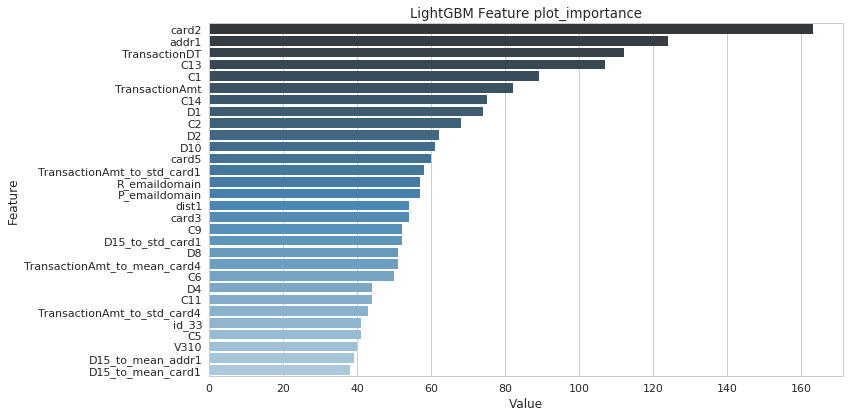

<Figure size 432x288 with 0 Axes>

In [30]:

# Feature importance with RANDOM validation sample
plot_importance(m_subset, X_train_tmp);


## Remove transaction datatime


### Iterate over potential columns to remove, then get validation performance.


In [31]:

features_to_drop = [None, 'TransactionDT', 'TransactionID']

for feature in features_to_drop:
    
    # Split data up and subsample
    X_train_tmp, y_train_tmp, X_val_tmp, y_val_tmp = create_training_val_set(
        df_subset, drop_features=feature, verbose=False, split_by_time=False)
    
    # Very basic initial parameters, just used for feature importance etc..
    m = LGBMClassifier(
        learning_rate=0.1, 
        n_estimators=100, 
        subsample=0.1, # Used to speed up training 
        colsample_bytree=0.5, 
        importance_type='split')
    
    m.fit(X=X_train_tmp.values, y=y_train_tmp.values)

    show_validation_error(m, X_train_tmp, y_train_tmp, X_val_tmp, y_val_tmp, model_name=f'Reduced feature set -- drop {feature}')
    

Ordering train/val split by TransactionDT
Results for model = Reduced feature set -- drop None:
	 Validation set: AUC ROC = 0.9284
	 Training set: AUC ROC = 0.9397
Ordering train/val split by TransactionDT
Removing features TransactionDT
Results for model = Reduced feature set -- drop TransactionDT:
	 Validation set: AUC ROC = 0.9268
	 Training set: AUC ROC = 0.9391
Ordering train/val split by TransactionDT
Removing features TransactionID
Results for model = Reduced feature set -- drop TransactionID:
	 Validation set: AUC ROC = 0.926
	 Training set: AUC ROC = 0.9401


In [10]:

# 'TransactionID' should be removed. As removing it improves the validation performance.
# Note, TransactionDT helps when the validation sample is random
# However, when then validation sample is time-dependent removing it helps the validation performance

features_to_drop = ['TransactionID', 'TransactionDT']


## 9. Feature correlations

* Are there any highly correlated features we should remove?


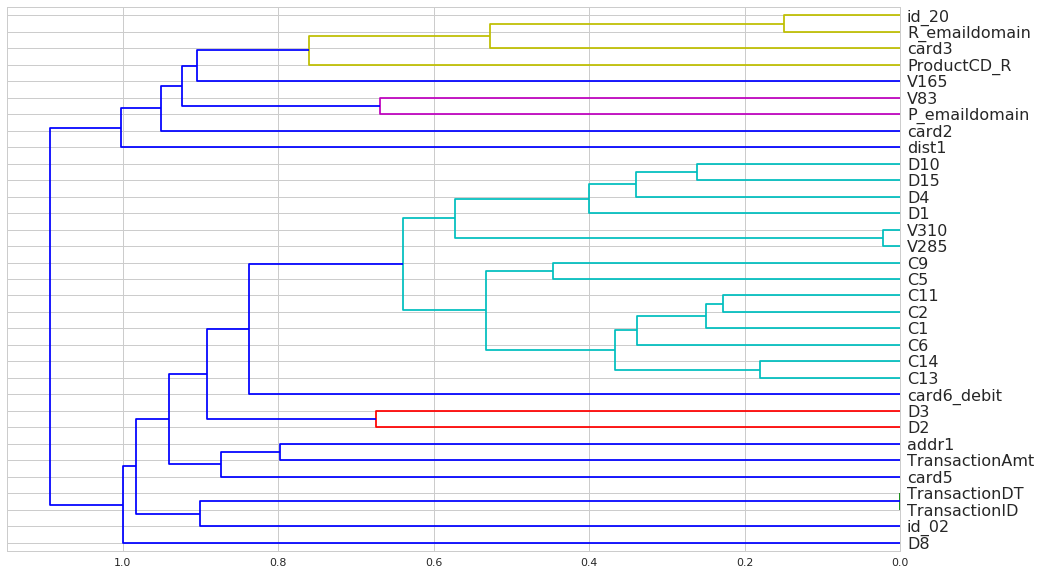

In [91]:

from scipy.cluster import hierarchy as hc
import scipy

corr = np.round(scipy.stats.spearmanr(X_train_tmp).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train_tmp.columns, orientation='left', leaf_font_size=16)
plt.show()



### 9.1 Effect of removing correlated features on validation accuracy.


In [93]:

correlated_features = [None, 'V310', 'C14', 'id_20', 'C1', 'D10']

for feature in correlated_features:
    
    # first drop all the features in the list features to drop.
    features_to_drop_tmp = features_to_drop
    
    # Add to feature to drop from this test.
    if feature is not None:
        features_to_drop_tmp = features_to_drop_tmp + [feature]
        
    # Split data up and subsample
    X_train_tmp, y_train_tmp, X_val_tmp, y_val_tmp = create_training_val_set(
        df_subset, drop_features=feature, verbose=False, split_by_time=True)
    
    # Very basic initial parameters, just used for feature importance etc..
    m = LGBMClassifier(
        learning_rate=0.1, 
        n_estimators=200, 
        subsample=0.1, # Used to speed up training 
        colsample_bytree=0.5, 
        importance_type='split')
    
    m.fit(X=X_train_tmp.values, y=y_train_tmp.values)

    show_validation_error(m, X_train_tmp, y_train_tmp, X_val_tmp, y_val_tmp, model_name=f'Reduced feature set -- drop {feature}')


Ordering train/val split by TransactionDT
Results for model = Reduced feature set -- drop None:
	 Validation set: AUC ROC = 0.8955
	 Training set: AUC ROC = 0.9572
Ordering train/val split by TransactionDT
Removing features V310
Results for model = Reduced feature set -- drop V310:
	 Validation set: AUC ROC = 0.8936
	 Training set: AUC ROC = 0.9561
Ordering train/val split by TransactionDT
Removing features C14
Results for model = Reduced feature set -- drop C14:
	 Validation set: AUC ROC = 0.8938
	 Training set: AUC ROC = 0.9573
Ordering train/val split by TransactionDT
Removing features id_20
Results for model = Reduced feature set -- drop id_20:
	 Validation set: AUC ROC = 0.8969
	 Training set: AUC ROC = 0.9566
Ordering train/val split by TransactionDT
Removing features C1
Results for model = Reduced feature set -- drop C1:
	 Validation set: AUC ROC = 0.8935
	 Training set: AUC ROC = 0.9565
Ordering train/val split by TransactionDT
Removing features D10
Results for model = Reduced 

In [11]:

# From above we should drop the feature C14 and id_20 -- base on random shuffel val
# Drop D10 based on time-split val sample.
features_to_drop += ['C14', 'id_20']


In [12]:
 
# Features to remove from investigation.
print(f'List of Features to remove {features_to_drop}')


List of Features to remove ['TransactionID', 'TransactionDT', 'C14', 'id_20']


# Partial dependent plot -- Understand the features better.


In [46]:

df_encoded.loc[:, features_to_keep].head()


card2  TransactionAmt  addr1  TransactionID   C13   C1  C14  card5    D15  \
0    304            29.0    109        2987001   1.0  1.0  1.0      3    0.0   
1    455            49.0     83        2987005   1.0  1.0  1.0     93    0.0   
2      1            15.0    116        2987008   1.0  1.0  1.0     93   42.0   
3    318            50.0     53        2987012   6.0  4.0  3.0     93  107.0   
4    203            40.0    112        2987013  24.0  6.0  6.0     93   45.0   

     D10  ...     id_02  card6_debit    D3   C9  id_20  V285  V83   V310  \
0    0.0  ...  128244.0          NaN   7.0  0.0      0   0.0  1.0    0.0   
1    0.0  ...  128244.0          NaN   7.0  1.0      0   0.0  1.0    0.0   
2   10.0  ...   98945.0          NaN   7.0  0.0    228   0.0  1.0    0.0   
3  107.0  ...  128244.0          NaN  11.0  1.0      0   1.0  1.0   60.0   
4   45.0  ...  128244.0          NaN  10.0  3.0      0   2.0  1.0  100.0   

     V165  isFraud  
0     0.0        0  
1     0.0        0  
2  5155.0        0  
3     0.0        0  
4     0.0        0  

[5 rows x 34 columns]

In [38]:

# List of features to have a closer look at.
features_to_inspect = ['card2', 'addr1','C13', 'TransactionAmt', 'C1', 'D2']


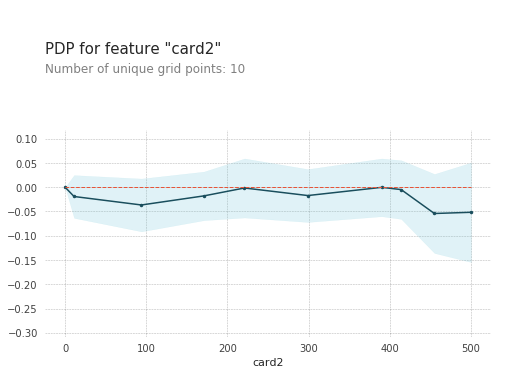

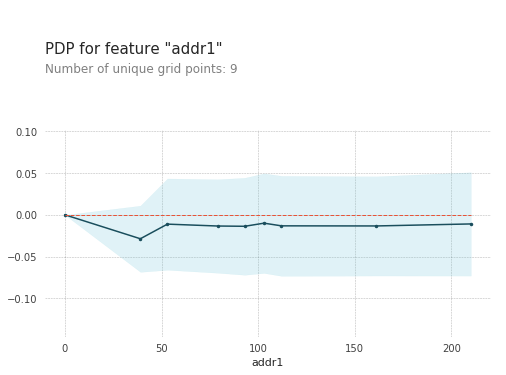

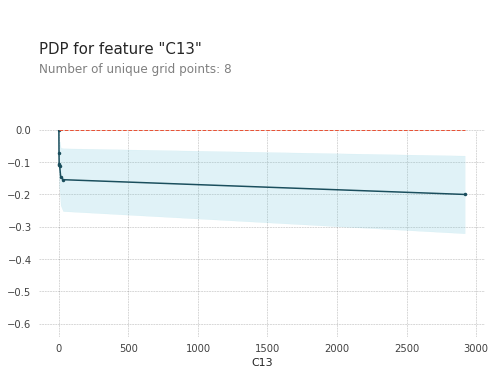

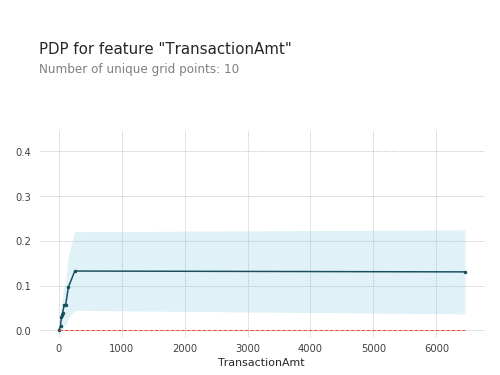

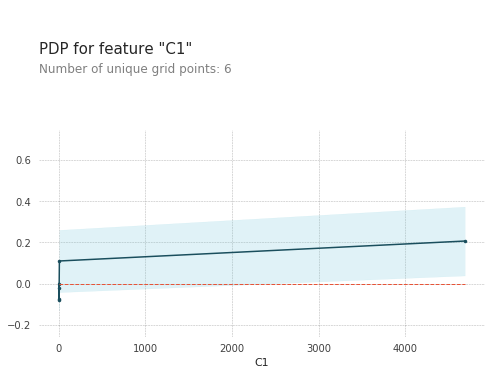

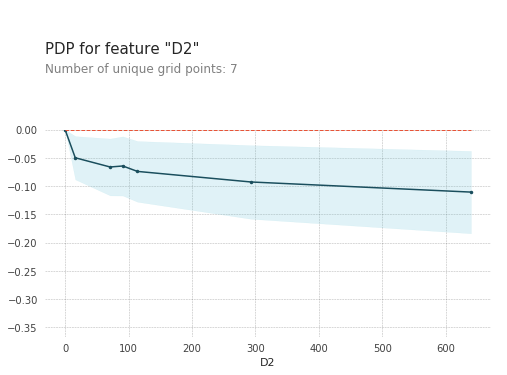

In [39]:

for test_feature in features_to_inspect:
    pdp_isolate = pdp.pdp_isolate(model=m_subset, 
        dataset=X_train_tmp, model_features=X_train_tmp.columns.values, feature=test_feature)
    pdp.pdp_plot(pdp_isolate, feature_name=test_feature, figsize=(8,6));


## 11. Train a good model -- use the validation set for early stopping


In [30]:

# Split data up and subsample
X_train_tmp, y_train_tmp, X_val_tmp, y_val_tmp = create_training_val_set(
    df_subset, verbose=False, split_by_time=True, drop_features=features_to_drop)


Ordering train/val split by TransactionDT
Removing features ['TransactionID', 'TransactionDT', 'C14', 'id_20']


In [32]:

params = {'num_leaves': 30,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 8,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.5,
          "bagging_seed": 11,
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.5,
         }

# Very basic initial parameters, just used for feature importance etc..
m = LGBMClassifier(n_estimators=500, **params)

# resample training data.
(X_train_res, y_train_res) = random_over_sampler(X_train_tmp, y_train_tmp)

# Balanced classes
m.fit(X=X_train_res.values, y=y_train_res.values, 
      eval_names = ['Train', 'Validation'],
      eval_set=[(X_train_res.values, y_train_res.values),(X_val_tmp.values, y_val_tmp.values)],
      eval_metric='auc', 
      early_stopping_rounds=5,
      verbose=20
     )


Check class imbalance..Should be equal post Oversampling


1    398840
0    398840
dtype: int64

Training until validation scores don't improve for 5 rounds.
[20]	Train's binary_logloss: 0.559977	Train's auc: 0.879384	Validation's binary_logloss: 0.551476	Validation's auc: 0.859407
[40]	Train's binary_logloss: 0.492168	Train's auc: 0.887665	Validation's binary_logloss: 0.479141	Validation's auc: 0.864544
[60]	Train's binary_logloss: 0.454533	Train's auc: 0.893759	Validation's binary_logloss: 0.438068	Validation's auc: 0.869584
[80]	Train's binary_logloss: 0.430109	Train's auc: 0.89877	Validation's binary_logloss: 0.411984	Validation's auc: 0.873332
[100]	Train's binary_logloss: 0.41409	Train's auc: 0.902899	Validation's binary_logloss: 0.39507	Validation's auc: 0.876407
[120]	Train's binary_logloss: 0.401298	Train's auc: 0.9068	Validation's binary_logloss: 0.382691	Validation's auc: 0.878951
[140]	Train's binary_logloss: 0.391608	Train's auc: 0.910355	Validation's binary_logloss: 0.372751	Validation's auc: 0.88182
[160]	Train's binary_logloss: 0.383322	Train's auc: 0.913795	Valida

LGBMClassifier(bagging_seed=11, boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.5, importance_type='split',
               learning_rate=0.03, max_depth=8, min_child_samples=79,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
               n_jobs=-1, num_leaves=30, objective='binary', random_state=None,
               reg_alpha=0.3, reg_lambda=0.3, silent=True, subsample=0.5,
               subsample_for_bin=200000, subsample_freq=3, verbosity=-1)

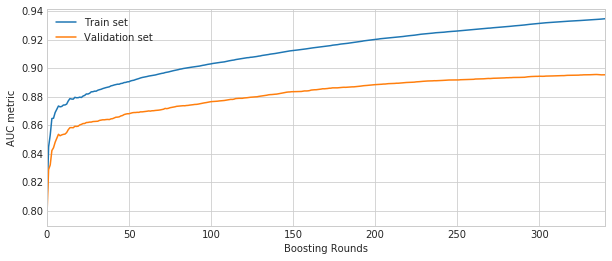

In [33]:
# Plot model complexity

plot_model_complexity_curve(m, metric='auc')


In [34]:
            
show_validation_error(m, X_train_tmp, y_train_tmp, X_val_tmp, y_val_tmp, 
                      model_name=f'Big model')


Results for model = Big model:
	 Validation set: AUC ROC = 0.8956
	 Training set: AUC ROC = 0.9339





# 10. Test set predictions

Load in the process the test set in a manner identical to the training set

* Compare validation accuracy with test set accuracy


In [8]:

def load_testset():
    # Load in the test data
    df_test_transaction = pd.read_csv(f'{PATH}test_transaction.csv', low_memory=False)
    df_test_identity = pd.read_csv(f'{PATH}test_identity.csv', low_memory=False)
    # Combine the transaction and identity datasets.
    X_test_set_raw = df_test_transaction.merge(right=df_test_identity, how='left', on='TransactionID')
    # Add features
    X_test_set_raw = add_features(X_test_set_raw, feature_set_names=['agg_spend_stats'])
    # Remove infinite values..
    X_test_set_raw = clean_inf_nan(X_test_set_raw)
    return X_test_set_raw

print('Load raw test set data...')
# Only need to run this code once.
X_test_set_raw = load_testset()
# Save raw test set data to feather format.
X_test_set_raw.to_feather('./tmp/raw_test_data.feather')


Load raw test set data...
Adding aggreate amount spent stats...


In [12]:

# Load test set data.
X_test_set_raw = pd.read_feather('./tmp/raw_test_data.feather')


In [29]:

print('Preprocessing test set data...')

# Update the types of all non-numeric columns
X_test_set = convert_to_cats(X_test_set_raw, force_cats=cat_variables)

# Fill is na's and make new columns with na bool
X_test_set = fix_na_dataframe(X_test_set)

# Force the numerical encodings from the train set onto the test set
apply_cats(X_test_set, df_processed)

## Convert to numerical codes.
X_test_set_proc = numericalize_cat_variables(X_test_set, max_n_cat=5)


Preprocessing test set data...


In [31]:

# is Fraud is not part of this dataset.
features_to_keep.remove('isFraud')

# Make sure all the features are there..
for feature_ in features_to_keep:
    if feature_ not in X_test_set_proc.columns.values:
        print(f'Problem. Missing features...{feature_}')


In [32]:

# is Fraud is not part of this dataset.
#features_to_keep.remove('isFraud')

# Only keep the relevant features.
X_test_set_proc = X_test_set_proc.loc[:, features_to_keep]
X_test_set_proc = X_test_set_proc.drop(features_to_drop, axis=1)


MemoryError: Unable to allocate array with shape (396, 506691) and data type float64

In [26]:
# Make sure all the features are there
X_test_set_proc.shape


(506691, 71)


## 10.1 Train a model on the full dataset


In [15]:

def create_final_train_set(df, features_to_drop, dependent_var='isFraud'):
    """Create X, y from using the full dataset. Drop unwanted columns.
    """
    df_local = df.drop(features_to_drop, axis=1)
    X_all, y_all = seperate_dependent_var(df_local, dependent_var)
    return X_all, y_all

def predict_test_set(m, X, file_prefix, df_test_raw):
    """Make forcast on the test set using the model m
    df_raw is needed as it contains the TransactionID values.
    """
    save_dir = f'./predictions/fraud_pred_{file_prefix}.csv'
    print(f'Saving data to {save_dir}')
    pos_prediction = m.predict_proba(X)[:,1]
    prediction_test_set = pd.Series(pos_prediction, index=df_test_raw.TransactionID.values)
    prediction_test_set.name = 'isFraud'
    prediction_test_set.index.name = 'TransactionID'
    prediction_test_set.to_csv(save_dir, header=['isFraud'])
    
def save_prediction(pos_prediction, file_prefix, df_test_raw):
    """Make forcast on the test set using the model m
    df_raw is needed as it contains the TransactionID values.
    """
    save_dir = f'./predictions/fraud_pred_{file_prefix}.csv'
    print(f'Saving data to {save_dir}')
    prediction_test_set = pd.Series(pos_prediction, index=df_test_raw.TransactionID.values)
    prediction_test_set.name = 'isFraud'
    prediction_test_set.index.name = 'TransactionID'
    prediction_test_set.to_csv(save_dir, header=['isFraud'])


In [17]:

X_all, y_all = create_final_train_set(df_subset, features_to_drop)


In [18]:

params = {'num_leaves': 62,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 8,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.5,
          "bagging_seed": 11,
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.5,
         }

m_final = LGBMClassifier(n_estimators=200, **params)

# resample training data.
(X_train_res, y_train_res) = random_over_sampler(X_all, y_all)

# Balanced classes
m_final.fit(X=X_train_res.values, y=y_train_res.values)


Check class imbalance..Should be equal post Oversampling


1    569877
0    569877
dtype: int64

LGBMClassifier(bagging_seed=11, boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.5, importance_type='split',
               learning_rate=0.03, max_depth=8, min_child_samples=79,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
               n_jobs=-1, num_leaves=62, objective='binary', random_state=None,
               reg_alpha=0.3, reg_lambda=0.3, silent=True, subsample=0.5,
               subsample_for_bin=200000, subsample_freq=3, verbosity=-1)

In [19]:

print('Making test set predictions..')
predict_test_set(m_final, X=X_test_set_proc, file_prefix='fullset_2', df_test_raw=X_test_set_raw)


Making test set predictions..
Saving data to ./predictions/fraud_pred_fullset_2.csv


In [ ]:

train['P_email']=(train['P_emaildomain']=='xmail.com')
train['R_email']=(train['R_emaildomain']=='xmail.com')
test['P_email']=(test['P_emaildomain']=='xmail.com')
test['R_email']=(test['R_emaildomain']=='xmail.com')



## Correlate Validation set and test set accuracy.



## Model to predict validation time-split, what are the important features?

## Predictions with CV -- early stopping predictions

In [16]:

from sklearn.model_selection import KFold


In [17]:

params = {'num_leaves': 62,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 8,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.5,
          "bagging_seed": 11,
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.5,
         }


# # Create X, y using the full dataset
X, y = create_final_train_set(df_subset, features_to_drop)

# CV code, can make predictions for each fold and then
# average then together to form a single predictions.
n_folds = 8
folds = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

# Create zero predictions dataframe
predictions = np.zeros(len(X_test_set_proc))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    
    print(f'Running fold={fold_}')  
    x_train_fold, y_train_fold = X.iloc[trn_idx,:], y[trn_idx]
    x_val_fold, y_val_fold = X.iloc[val_idx,:], y[val_idx]
    
    m_fold = LGBMClassifier(n_estimators=300, **params)
    
    # Balanced classes
    m_fold.fit(
        X=x_train_fold.values, y=y_train_fold.values, 
        eval_names = ['Train', 'Validation'],
        eval_set=[(x_train_fold.values, y_train_fold.values),
                  (x_val_fold.values, y_val_fold.values)],
        eval_metric='auc', 
        early_stopping_rounds=40,
        verbose=40)
    
    prediction_fold = m_fold.predict_proba(X_test_set_proc)[:,1]
    predictions += prediction_fold/n_folds

print('Save testset predictions...')
save_prediction(predictions, file_prefix='cv_method', df_test_raw=X_test_set_raw)
